In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as T
from torch import optim
import numpy as np
import random
from torch.autograd import Variable

import IPython.display as display
import PIL.Image

In [2]:
seed = 2

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:
mean=np.array([0.485, 0.456, 0.406])
std=np.array([0.229, 0.224, 0.225])
LOWER_IMAGE_BOUND = torch.tensor((-mean / std).reshape(1, -1, 1, 1)).float()
UPPER_IMAGE_BOUND = torch.tensor(((1 - mean) / std).reshape(1, -1, 1, 1)).float()

In [4]:
# Normalize an image
def deprocess(img):
    inv_normalize = T.Normalize(
       mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
       std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_normalize(img)
    img = 255*img
    return img.type(torch.uint8)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img).astype(np.uint8)))

In [5]:
base_model = models.resnet50(weights="DEFAULT")

In [24]:
split_block = 8
model = nn.Sequential(*nn.ModuleList(list(base_model.children())[:split_block]))

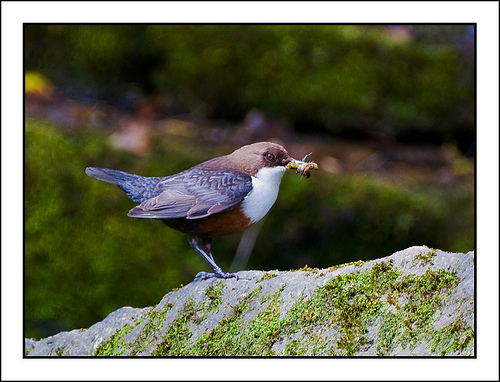

In [19]:
inp_img_path = "/u/abhi24/Datasets/NaturalImages/imagenet/ILSVRC/Data/CLS-LOC/val/n01601694/ILSVRC2012_val_00020349.JPEG"
inp_img = PIL.Image.open(inp_img_path)
show(inp_img)

In [8]:
def calc_loss(img, model):
    act = model(img)
    loss = torch.nn.MSELoss(reduction='mean')(act, torch.zeros_like(act))
    return loss

In [9]:
def run_grad_ascent(orig_img, model, step_size=0.09, iters=50):
    updated_img = orig_img.clone()
    updated_img.requires_grad = True
    updated_img.retain_grad()
    for it in range(iters):
        loss = calc_loss(updated_img, model)
        loss.backward()
        if it % 10 == 0:
            display.clear_output(wait=True)
            show(deprocess(updated_img[0]).detach().permute(1,2,0))
            print((updated_img - orig_img).mean())
        grads = updated_img.grad.data / (torch.std(updated_img.grad.data) + 1e-8)
        updated_img.data = updated_img.data + step_size * grads
        updated_img.data = torch.clamp(updated_img.data, min=LOWER_IMAGE_BOUND, max=UPPER_IMAGE_BOUND)
        model.zero_grad();updated_img.grad.data.zero_()
    print((updated_img - orig_img).mean())
    return updated_img

In [10]:
preprocess = T.Compose([
   T.Resize(256),
   T.CenterCrop(224),
   T.ToTensor(),
   T.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

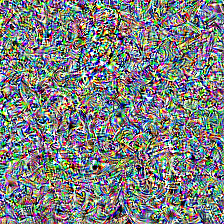

tensor(-0.0094, grad_fn=<MeanBackward0>)
tensor(-0.0083, grad_fn=<MeanBackward0>)


In [26]:
# inp_tensor = preprocess(inp_img).unsqueeze(0)
# inp_tensor = Variable(inp_tensor, requires_grad=True)
inp_img = PIL.Image.fromarray(np.random.randint(low=0, high=256, size=(300, 300, 3)).astype(np.uint8))
inp_tensor = preprocess(inp_img).unsqueeze(0)
out_img = run_grad_ascent(inp_tensor, model, step_size=0.4, iters=100)

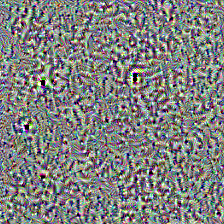

tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0121, grad_fn=<MeanBackward0>)


In [16]:
# inp_tensor = preprocess(inp_img).unsqueeze(0)
# inp_tensor = Variable(inp_tensor, requires_grad=True)
inp_img = PIL.Image.fromarray(np.random.randint(low=0, high=256, size=(300, 300, 3)).astype(np.uint8))
inp_tensor = preprocess(inp_img).unsqueeze(0)
out_img = run_grad_ascent(inp_tensor, model, step_size=0.08, iters=100)

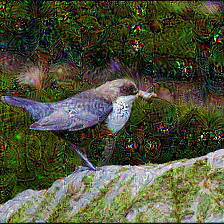

tensor(0.0962, grad_fn=<MeanBackward0>)
tensor(0.1137, grad_fn=<MeanBackward0>)


In [205]:
# inp_tensor = preprocess(inp_img).unsqueeze(0)
# inp_tensor = Variable(inp_tensor, requires_grad=True)
inp_tensor = preprocess(inp_img).unsqueeze(0)
out_img = run_grad_ascent(inp_tensor, model)

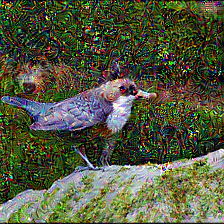

tensor(0.1980, grad_fn=<MeanBackward0>)
tensor(0.2163, grad_fn=<MeanBackward0>)


In [208]:
# inp_tensor = preprocess(inp_img).unsqueeze(0)
# inp_tensor = Variable(inp_tensor, requires_grad=True)
inp_tensor = preprocess(inp_img).unsqueeze(0)
out_img = run_grad_ascent(inp_tensor, model, iters=100)

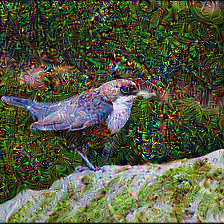

tensor(0.2068, grad_fn=<MeanBackward0>)
tensor(0.2245, grad_fn=<MeanBackward0>)


In [210]:
inp_tensor = preprocess(inp_img).unsqueeze(0)
out_img = run_grad_ascent(inp_tensor, model, iters=100)

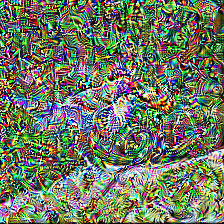

tensor(0.7414, grad_fn=<MeanBackward0>)
tensor(0.7436, grad_fn=<MeanBackward0>)


In [213]:
inp_tensor = preprocess(inp_img).unsqueeze(0)
out_img = run_grad_ascent(inp_tensor, model, iters=1000)

## Testing multiple model training

In [3]:
from torchvision.datasets.cifar import CIFAR10
from torch.utils.data import Subset
from torch.utils.data import DataLoader

In [4]:
device_ids = [0, 1, 2, 3]
batch_size = len(device_ids) * 64
device = torch.device('cuda:{}'.format(device_ids[0]))

In [5]:
IMAGE_SIZE = 32
num_classes = 10

transform = T.Compose(
    [
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(
            (0.4914, 0.4822, 0.4465), 
            (0.2023, 0.1994, 0.2010)
        ),
    ]
)
train_dataset = CIFAR10(
    root="./imgs/cifar10", train=True, download=True, transform=transform
)
test_dataset = CIFAR10(
    root="./imgs/cifar10", train=False, download=True, transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
test_loader = DataLoader(test_dataset, batch_size=64)

In [7]:
loss_fn = nn.CrossEntropyLoss()
model = models.resnet34
model.fc = nn.Linear(512, num_classes)
indices = np.random.permutation(len(train_dataset))

In [8]:
optim = torch.optim.Adam

c_models = []
c_optims = []
c_dsets = []
c_dloaders = []

num_clients = 2
samples_per_client = 10000

for i in range(num_clients):
    c_model = nn.DataParallel(model().to(device), device_ids=device_ids)
    c_optim = optim(c_model.parameters(), lr=3e-4)
    c_idx = indices[i*samples_per_client: (i+1)*samples_per_client]
    c_dset = Subset(train_dataset, c_idx)
    c_dloader = DataLoader(c_dset, batch_size=64, shuffle=True)

    c_models.append(c_model)
    c_optims.append(c_optim)
    c_dsets.append(c_dset)
    c_dloaders.append(c_dloader)

In [9]:
total_epochs = 50
for epoch in range(total_epochs):
    for client_num in range(num_clients):
        c_model = c_models[client_num]
        c_model.train()
        correct, total = 0, 0
        for x, y_hat in test_loader:
            with torch.no_grad():
                x, y_hat = x.to(device), y_hat.to(device)
                y = c_model(x)
                loss = loss_fn(y, y_hat)
                correct += (y.argmax(dim=1) == y_hat).sum()
                total += x.shape[0]
        print("epoch {}, client {}, acc {:.4f}".format(epoch, client_num, correct/total))

    for client_num in range(num_clients):
        c_model = c_models[client_num]
        c_model.eval()
        c_optim = c_optims[client_num]
        c_dloader = c_dloaders[client_num]
        for x, y_hat in c_dloader:
            x, y_hat = x.to(device), y_hat.to(device)
            c_optim.zero_grad()
            y = c_model(x)
            loss = loss_fn(y, y_hat)
            loss.backward()
            c_optim.step()


epoch 0, client 0, acc 0.0042
epoch 0, client 1, acc 0.0013
epoch 1, client 0, acc 0.1348
epoch 1, client 1, acc 0.1494
epoch 2, client 0, acc 0.1833
epoch 2, client 1, acc 0.1967
epoch 3, client 0, acc 0.2455
epoch 3, client 1, acc 0.2474
epoch 4, client 0, acc 0.2950
epoch 4, client 1, acc 0.2974
epoch 5, client 0, acc 0.3312
epoch 5, client 1, acc 0.3658
epoch 6, client 0, acc 0.3633
epoch 6, client 1, acc 0.3702
epoch 7, client 0, acc 0.4392
epoch 7, client 1, acc 0.3972
epoch 8, client 0, acc 0.4191
epoch 8, client 1, acc 0.3774
epoch 9, client 0, acc 0.4433
epoch 9, client 1, acc 0.3884
epoch 10, client 0, acc 0.4540
epoch 10, client 1, acc 0.4254
epoch 11, client 0, acc 0.4697
epoch 11, client 1, acc 0.4413
epoch 12, client 0, acc 0.4833
epoch 12, client 1, acc 0.4828
epoch 13, client 0, acc 0.4983
epoch 13, client 1, acc 0.4813
epoch 14, client 0, acc 0.5155
epoch 14, client 1, acc 0.4819
epoch 15, client 0, acc 0.5120
epoch 15, client 1, acc 0.4851
epoch 16, client 0, acc 0.51

KeyboardInterrupt: 

In [8]:
s_model = nn.DataParallel(model().to(device), device_ids=device_ids)
s_optim = torch.optim.SGD(s_model.parameters(), lr=0.01,
                          momentum=0.9, weight_decay=5e-4)
s_idx = indices[0:50000]
s_dset = Subset(train_dataset, s_idx)
s_dloader = DataLoader(s_dset, batch_size=64, shuffle=True)

In [9]:
total_epochs = 100
for epoch in range(total_epochs):
    s_model.eval()
    correct, total = 0, 0
    for x, y_hat in test_loader:
        with torch.no_grad():
            x, y_hat = x.to(device), y_hat.to(device)
            y = s_model(x)
            loss = loss_fn(y, y_hat)
            correct += (y.argmax(dim=1) == y_hat).sum()
            total += x.shape[0]
    print("epoch {}, acc {:.4f}".format(epoch, correct/total))

    s_model.train()
    for i, (x, y_hat) in enumerate(s_dloader):
        x, y_hat = x.to(device), y_hat.to(device)
        s_optim.zero_grad()
        y = s_model(x)
        loss = loss_fn(y, y_hat)
        loss.backward()
        s_optim.step()
        if i % 50 == 0:
            print(loss.item())

epoch 0, acc 0.0000
6.98486328125
2.70963716506958
2.0997836589813232
0.5525210499763489
0.6236459016799927
0.6905953288078308
0.39343127608299255
0.5659556984901428
0.6398298740386963
0.508870005607605
0.499637246131897
0.5657274723052979
0.6213939785957336
0.5988869667053223
epoch 40, acc 0.7780
0.42353618144989014
0.6016494631767273
0.4870825707912445
0.5306821465492249
0.522686243057251
0.674122154712677
0.5481606721878052
0.5452703237533569
0.5352471470832825
0.4670476019382477
0.5020848512649536
0.5537342429161072
0.3064631223678589
0.6768444180488586
0.39003968238830566
0.6446136832237244
epoch 41, acc 0.7974
0.5428318381309509
0.4646252691745758
0.6508244872093201
0.6469076871871948
0.4891758859157562
0.5650864839553833
0.46619632840156555
0.444280207157135
0.6510992646217346
0.3963761329650879
0.6670657396316528
0.5199795365333557
0.6907184720039368
0.8128859996795654
0.37643879652023315
0.5122395753860474
epoch 42, acc 0.7945
0.646515429019928
0.6409192085266113
0.38038390874

In [11]:
correct / total

tensor(0.8219, device='cuda:0')

# Main Idea Investigation